## Question P2: Ensemble of Neural Networks (35 Points Total)
In this part of the assignment, you will train an ensemble of neural networks for classifying hand written digits in the MNIST dataset. You will take the code provided in the following cell and extend it to build an ensemble of single hidden layer MLP as per the specifications provided in the questions below. 

For the data, you need to download the MNIST dataset from ``http://yann.lecun.com/exdb/mnist/`` and place the files in the directory ``./data/MNIST``. 

In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the MNIST dataset
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [ ]:
# define the multi-layer perceptron model
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

# define the training loop
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        loss = F.nll_loss(output, target)
        # backward pass through the cross-entropy loss function and the model
        loss.backward()

        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# define the testing loop
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        print(torch.flatten(pred))
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list = []
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))


# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


In [ ]:
# build the model and execute the training and testing
# initialize some hyper-paramters
n_hidden = 4  # number of hidden units
learning_rate = 0.01
moment = 0.5
nepochs = 1

# build the actual model
model_fnn = FC2Layer(input_size, n_hidden, output_size)
# model_fnn.to(device)
# initialize the optimizer
optimizer = optim.SGD(model_fnn.parameters(),
                      lr=learning_rate,
                      momentum=moment)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

# train the model for one epoch
for epoch in range(0, nepochs):
    train(epoch, model_fnn)
    test(model_fnn)

### Question P2.a: Ensemble of networks of same size but initialized with a different seed (20 Points)
Extend the above code to create an ensemble of `k` single hidden layer MLP models, each initialized with a different random seed. Train each model inside the ensemble for exactly `1` epoch and report the performance of the individual models and the ensemble model on the test set. For the purpose of ensembling, you can take a majority vote of the model outputs. 

At a high level you need to perform the following tasks:
1. Initialize `k` models with different random seed (for some value of k): (**5 points**)
2. Extend the train() function to train individual models inside the ensemble: (**5 points**)
3. Extend the test() function to estimate the accuracy of the individual models and the ensemble model: (**5 points**)
4. Repeat the above process with different values of `k`. For this exercise use $k = \{1, 2, 4, 8, 16, 32 \}$, and plot a graph with `k` on the x-axis and ensemble model performance on the y-axis. (**5 points**)

In [189]:
class EnsembleMLP(nn.Module):
    def __init__(self,
                 k,
                 input_size,
                 n_hidden,
                 output_size,
                 learning_rate=learning_rate,
                 moment=moment,
                 verbose=True,
                 manual_seed=None):
        self.verbose = verbose
        super(EnsembleMLP, self).__init__()
        self.input_size = input_size
        self.k = k
        self.models = nn.ModuleList()
        self.optimizers = []
        if manual_seed is not None:
            torch.manual_seed(manual_seed)
        for i in range(k):
            if manual_seed is None: torch.manual_seed(i)
            model = FC2Layer(input_size, n_hidden, output_size)
            optimizer = optim.SGD(model.parameters(),
                                  lr=learning_rate,
                                  momentum=moment)
            self.models.append(model)
            self.optimizers.append(optimizer)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return [model.network(x) for model in self.models]

    # define the training loop
    def train(self, epoch, loader=train_loader):
        for i, (model,
                optimizer) in enumerate(zip(self.models, self.optimizers)):
            model.train()

            for batch_idx, (data, target) in enumerate(loader):

                optimizer.zero_grad()
                # forward pass through the model
                output = model(data)
                # forward pass through the cross-entropy loss function
                loss = F.nll_loss(output, target)
                # backward pass through the cross-entropy loss function and the model
                loss.backward()

                optimizer.step()
                if batch_idx % 200 == 0 and self.verbose:
                    print('Model {} Epoch {}: [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.
                          format(i, epoch, batch_idx * len(data),
                                 len(loader.dataset),
                                 100. * batch_idx / (len(loader) - 1),
                                 loss.item()))
                
                if batch_idx == len(loader)-1:
                    print('Model {} Epoch {} Final Train Loss: {:.6f}'.
                        format(i, epoch, loss.item()))

    def eval(self):
        for model in self.models:
            model.eval()

    def test_one(self, model, loader=test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        pred_list = []
        for data, target in loader:
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(
                1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            pred_list.append(pred)

        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print(
            '\nk={} Ensemble Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
            .format(self.k, test_loss, correct, len(loader.dataset),
                    accuracy))
        return test_loss, accuracy

    def test(self):
        if self.k == 1:
            return self.test_one(self.models[0])
        self.eval()
        test_loss = torch.zeros(self.k)
        correct = torch.zeros(self.k)
        ensemble_test_loss = 0
        ensemble_correct = 0
        test_size = len(test_loader.dataset)
        for data, target in test_loader:
            preds = []
            for m, model in enumerate(self.models):
                output = model(data)
                test_loss[m] += F.nll_loss(
                    output, target,
                    reduction='sum').item()  # sum up batch loss
                pred = output.data.max(
                    1, keepdim=True)[1]  # get the index of the max log-probability
                preds.append(pred)

                correct[m] += pred.eq(
                    target.data.view_as(pred)).cpu().sum().item()

            ensemble_pred = torch.mode(torch.stack(preds), 0).values
            # print(ensemble_pred)
            ensemble_correct += ensemble_pred.eq(target.data.view_as(ensemble_pred)).cpu().sum().item()

        for m, model in enumerate(self.models):
            test_loss[m] /= test_size
            accuracy = 100. * correct[m] / test_size
            print(
                'Model {} Test Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'
                .format(m, test_loss[m].item(), correct[m].item(), test_size,
                        accuracy.item()))

        ensemble_test_loss = test_loss.mean()
        ensemble_accuracy = 100. * ensemble_correct / test_size
        print('\nk={} Ensemble Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(self.k, ensemble_test_loss, ensemble_correct,
                     test_size, ensemble_accuracy))
        return ensemble_test_loss, ensemble_accuracy


In [98]:
# initialize some hyper-paramters
n_hidden = 4  # number of hidden units
learning_rate = 0.01
moment = 0.5
nepochs = 1

# build the actual model
model_ensemble = EnsembleMLP(2, input_size, n_hidden, output_size)
# model_ensemble.to(device)

# train the model for one epoch
for epoch in range(nepochs):
    print(f'======== TRAIN EPOCH {epoch} ========')
    model_ensemble.train(epoch)
    torch.save(model_ensemble.state_dict(), './model_ensemble')

    print(f'\n======== TEST EPOCH {epoch} ========')
    model_ensemble.test()

======== TRAIN EPOCH 0 ========
Model 0 Epoch 0: [0/60000 (0%)]	Loss: 2.333221
Model 0 Epoch 0: [6400/60000 (11%)]	Loss: 2.032293
Model 0 Epoch 0: [12800/60000 (21%)]	Loss: 1.932000
Model 0 Epoch 0: [19200/60000 (32%)]	Loss: 1.703176
Model 0 Epoch 0: [25600/60000 (43%)]	Loss: 1.595040
Model 0 Epoch 0: [32000/60000 (53%)]	Loss: 1.718608
Model 0 Epoch 0: [38400/60000 (64%)]	Loss: 1.470350
Model 0 Epoch 0: [44800/60000 (75%)]	Loss: 1.375910
Model 0 Epoch 0: [51200/60000 (85%)]	Loss: 1.602173
Model 0 Epoch 0: [57600/60000 (96%)]	Loss: 1.386774
Model 1 Epoch 0: [0/60000 (0%)]	Loss: 2.418856
Model 1 Epoch 0: [6400/60000 (11%)]	Loss: 2.182961
Model 1 Epoch 0: [12800/60000 (21%)]	Loss: 1.636517
Model 1 Epoch 0: [19200/60000 (32%)]	Loss: 1.557359
Model 1 Epoch 0: [25600/60000 (43%)]	Loss: 1.428287
Model 1 Epoch 0: [32000/60000 (53%)]	Loss: 1.362798
Model 1 Epoch 0: [38400/60000 (64%)]	Loss: 1.008451
Model 1 Epoch 0: [44800/60000 (75%)]	Loss: 1.095357
Model 1 Epoch 0: [51200/60000 (85%)]	Loss: 1

In [96]:
model_ensemble = EnsembleMLP(2, input_size, n_hidden, output_size)
model_ensemble.load_state_dict(torch.load('./model_ensemble'))
model_ensemble.test()
# print(model_ensemble.state_dict())


Model 0 Test: Average loss: 0.8811, Accuracy: 7265.0/10000 (73%)

Model 1 Test: Average loss: 0.8095, Accuracy: 7813.0/10000 (78%)


Ensemble Average loss: 0.8453, Accuracy: 7369/10000 (74%)



In [136]:
# k_list = [1, 2, 4, 8, 16, 32]
k_list = [1, 2, 4, 8, 16]
k_loss = []
k_acc = []
for k in k_list:
    print(f'======== k={k} ========')
    model_ensemble = EnsembleMLP(k,
                                 input_size,
                                 n_hidden,
                                 output_size,
                                 verbose=False)
    for epoch in range(nepochs):
        model_ensemble.train(epoch)
    loss, acc = model_ensemble.test()
    k_loss.append(loss)
    k_acc.append(acc)


======== k=1 ========
Model 0 Epoch 0: [29984/60000 (100%)]	Loss: 1.436171

k=1 Ensemble Average loss: 1.3269, Accuracy: 4862/10000 (49%)

======== k=2 ========
Model 0 Epoch 0: [29984/60000 (100%)]	Loss: 1.338912
Model 1 Epoch 0: [29984/60000 (100%)]	Loss: 1.064286
Model 0 Test: Average loss: 1.3308, Accuracy: 5010.0/10000 (50%)
Model 1 Test: Average loss: 0.8475, Accuracy: 7314.0/10000 (73%)

k=2 Ensemble Average loss: 1.0892, Accuracy: 6555/10000 (66%)

======== k=4 ========
Model 0 Epoch 0: [29984/60000 (100%)]	Loss: 1.418855
Model 1 Epoch 0: [29984/60000 (100%)]	Loss: 0.712352
Model 2 Epoch 0: [29984/60000 (100%)]	Loss: 0.641186
Model 3 Epoch 0: [29984/60000 (100%)]	Loss: 0.787955
Model 0 Test: Average loss: 1.3419, Accuracy: 4853.0/10000 (49%)
Model 1 Test: Average loss: 0.8254, Accuracy: 7339.0/10000 (73%)
Model 2 Test: Average loss: 0.7578, Accuracy: 7555.0/10000 (76%)
Model 3 Test: Average loss: 0.7377, Accuracy: 7676.0/10000 (77%)

k=4 Ensemble Average loss: 0.9157, Accuracy:

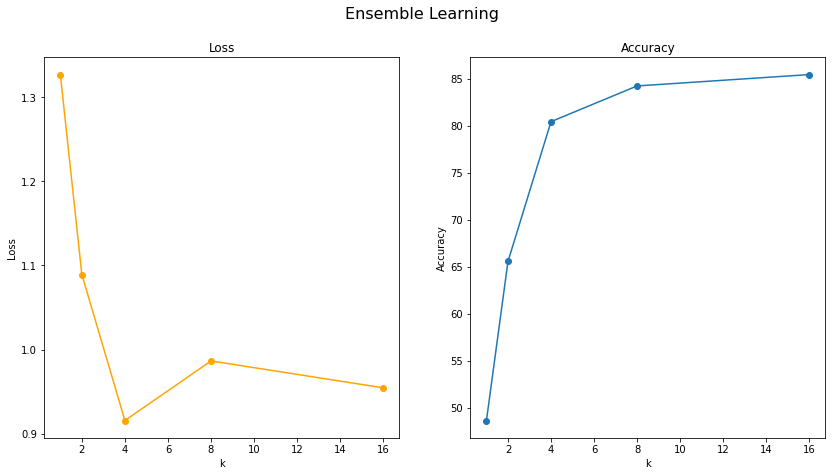

In [186]:
# Graph
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(14, 7))
fig.suptitle('Ensembled MLP', fontsize=16)

# plt.subplot(1, 2, 1)  # row 1, column 2, count 1
ax1.plot(k_list, k_loss, '-o', label='Loss', color='orange')
ax1.set_title('Loss')
ax1.set_xlabel('k')
ax1.set_ylabel('Loss')

ax2.plot(k_list, k_acc, '-o', label='Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.show()

### Question P2.b: Bagged networks  (15 Points)
Extend the above code to create a bag of `k` single hidden layer MLP models with each with `4` hidden units. Compare the performance of bags of different sizes `k`. In particular, compare the performance of `5` bages, with sizes $k = \{2, 4, 8, 16, 32\}$ respectively. To prevent additional sources of randomness, all the models within all the bags should be initialized to the same random seed. Train each model inside each bag for exactly `1` epoch. Report the final performance for each bag on the test set and compare it against each other. For the purpose of ensembling, you can take a majority vote of the model outputs. 

At a high level you need to perform the following tasks:
1. Create `k=5` bags of the training set of sizes $k = \{2, 4, 8, 16, 32\}$. (**5 points**)
2. Use the same extension to the train() function as in P2.a to train individual models in each bag: (**2.5 points**)
3. Use the same extension to the test() function as in P2.a to estimate the accuracy for each bag: (**2.5 points**)
4. Plot a graph with bag_size on the x-axis and bag performance on the y-axis. (**5 points**)

In [188]:
train_dataset = datasets.MNIST('./data/MNIST',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307, ), (0.3081, ))
                               ]))
bootstrap_sampler = torch.utils.data.RandomSampler(train_dataset,
                                                   replacement=True)
                                                   
bag_train_loader = torch.utils.data.DataLoader(train_dataset,
                                               sampler=bootstrap_sampler,
                                               batch_size=64,
                                               drop_last=True)


In [173]:
# initialize some hyper-paramters
n_hidden = 4  # number of hidden units
learning_rate = 0.01
moment = 0.5
nepochs = 1

# build the actual model
model_ensemble = EnsembleMLP(2, input_size, n_hidden, output_size, verbose=False)
# model_ensemble.to(device)

# train the model for one epoch
for epoch in range(nepochs):
    print(f'======== TRAIN EPOCH {epoch} ========')
    model_ensemble.train(epoch, loader=bag_train_loader)
    torch.save(model_ensemble.state_dict(), './model_ensemble')

    print(f'\n======== TEST EPOCH {epoch} ========')
    model_ensemble.test()


======== TRAIN EPOCH 0 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 1.376697
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 0.834718

======== TEST EPOCH 0 ========
Model 0 Test: Average loss: 1.3354, Accuracy: 4833.0/10000 (48%)
Model 1 Test: Average loss: 0.8489, Accuracy: 7201.0/10000 (72%)

k=2 Ensemble Average loss: 1.0921, Accuracy: 6606/10000 (66%)



In [190]:
# k_list = [2, 4, 8, 16, 32]
bagged_k_list = [2, 4, 8, 16]
bagged_k_loss = []
bagged_k_acc = []
for k in bagged_k_list:
    print(f'======== k={k} ========')
    model_ensemble = EnsembleMLP(k,
                                 input_size,
                                 n_hidden,
                                 output_size,
                                 manual_seed=42,
                                 verbose=False)
    for epoch in range(nepochs):
        model_ensemble.train(epoch, loader=bag_train_loader)
    loss, acc = model_ensemble.test()
    bagged_k_loss.append(loss)
    bagged_k_acc.append(acc)

======== k=2 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 0.861478
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 1.320757
Model 0 Test: Average loss: 0.9141, Accuracy: 7063.0/10000 (71%)
Model 1 Test: Average loss: 1.2888, Accuracy: 5527.0/10000 (55%)

k=2 Ensemble Average loss: 1.1014, Accuracy: 6146/10000 (61%)

======== k=4 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 0.910722
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 1.256852
Model 2 Epoch 0: [59904/60000 (100%)]	Loss: 0.732422
Model 3 Epoch 0: [59904/60000 (100%)]	Loss: 0.877135
Model 0 Test: Average loss: 0.9309, Accuracy: 6921.0/10000 (69%)
Model 1 Test: Average loss: 1.2668, Accuracy: 5302.0/10000 (53%)
Model 2 Test: Average loss: 0.7408, Accuracy: 7712.0/10000 (77%)
Model 3 Test: Average loss: 0.9326, Accuracy: 6930.0/10000 (69%)

k=4 Ensemble Average loss: 0.9678, Accuracy: 7906/10000 (79%)

======== k=8 ========
Model 0 Epoch 0: [59904/60000 (100%)]	Loss: 0.803493
Model 1 Epoch 0: [59904/60000 (100%)]	Loss: 1

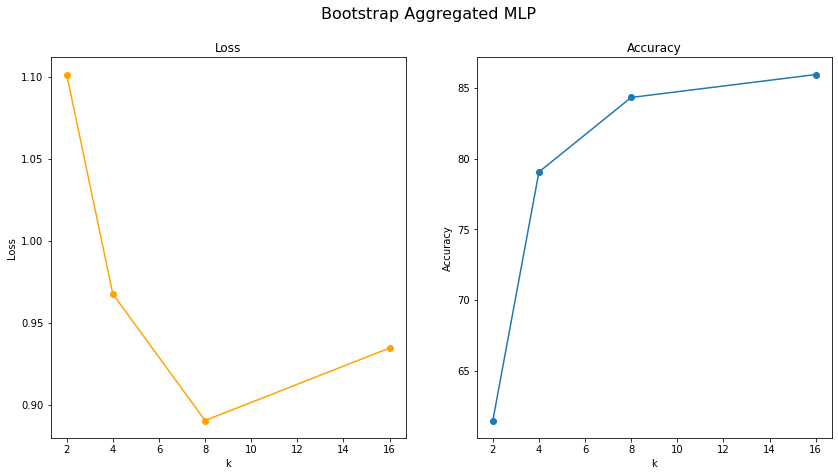

In [191]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Bootstrap Aggregated MLP', fontsize=16)

# plt.subplot(1, 2, 1)  # row 1, column 2, count 1
ax1.plot(bagged_k_list, bagged_k_loss, '-o', label='Loss', color='orange')
ax1.set_title('Loss')
ax1.set_xlabel('k')
ax1.set_ylabel('Loss')

ax2.plot(bagged_k_list, bagged_k_acc, '-o', label='Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.show()